In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pprint import pprint

def plot_tests(tests, figtitle):
    fig, axs = plt.subplots(3, len(tests), figsize=(20, 10))
    fig.suptitle(figtitle)

    for test in tests:
        parcel_size = get_parcel_size(test)

        builder_count, validator_count, regular_count = get_node_count(test)
        builder_seed_df, validator_seed_df, regular_seed_df = get_seed_df(test)

        # ? Convert from microseconds to seconds
        builder_seed_df = builder_seed_df / 1000000
        validator_seed_df = validator_seed_df / 1000000
        regular_seed_df = regular_seed_df / 1000000

        if len(tests) > 1:
            b_ax = axs[0, tests.index(test)]
            v_ax = axs[1, tests.index(test)]
            r_ax = axs[2, tests.index(test)]
        else:
            b_ax = axs[0]
            v_ax = axs[1]
            r_ax = axs[2]
        
        b_ax.scatter(range(len(builder_seed_df)), builder_seed_df)
        b_ax.set_title(f"Builder Seeding Time Per Block ({parcel_size} Parcel Size)")
        b_ax.set_xlabel("Block ID")
        b_ax.set_ylabel("Seeding Time (s)")

        sns.scatterplot(data=validator_seed_df.values, ax=v_ax)
        v_ax.legend().remove()
        v_ax.set_title(f"Validator Sampling Time Per Block ({parcel_size} Parcel Size)")
        v_ax.set_xlabel("Block ID")
        v_ax.set_ylabel("Sampling Time (s)")
        v_ax.axhline(y=4, color='red', linestyle='--', label='4 sec')
        v_ax.axhline(y=12, color='orange', linestyle='--', label='12 sec')

        sns.scatterplot(data=regular_seed_df.values, ax=r_ax)
        r_ax.legend().remove()
        r_ax.set_title(f"Regular Sampling Time Per Block ({parcel_size} Parcel Size)")
        r_ax.set_xlabel("Block ID")
        r_ax.set_ylabel("Sampling Time (s)")
        r_ax.axhline(y=4, color='red', linestyle='--', label='4 sec')
        r_ax.axhline(y=12, color='orange', linestyle='--', label='12 sec')

    plt.tight_layout()
    plt.show()

def get_node_count(test):
    test_files = os.listdir(test)
    csv_files = [file for file in test_files if file.endswith('.csv')]

    builder_count = [file for file in csv_files if "builder" in file]
    validator_count = [file for file in csv_files if "validator" in file and "nonvalidator" not in file]
    nonvalidator_count = [file for file in csv_files if "nonvalidator" in file]    

    builder_count = len(builder_count) / 2
    builder_count = int(builder_count)

    validator_count = len(validator_count) / 2
    validator_count = int(validator_count)

    nonvalidator_count = len(nonvalidator_count) / 2
    nonvalidator_count = int(nonvalidator_count)
    
    return builder_count, validator_count, nonvalidator_count

def get_seed_df_helper(files, node_type):
    if node_type == "builder":
        builder_file = files[0]
        builder_df = pd.read_csv(builder_file)
        builder_df = builder_df["Block Seeding Duration (us)"]    
        builder_df.dropna(inplace=True)
        builder_df = builder_df.astype(int)
        return builder_df

    df = pd.DataFrame()
    for file in files:
        
        node_name = os.path.basename(file)[3:10]

        temp_df = pd.read_csv(file)

        if node_type == "validator":
            temp_df = temp_df[["Row Sampling Latencies (us)", "Col Sampling Latencies (us)"]]
            seed_df = temp_df.max(axis=1)
            seed_df = seed_df.rename()
            seed_df = seed_df.rename(f"{node_name}_sampling_latencies_us")
            seed_df.dropna(inplace=True)
            seed_df = seed_df.astype(int)
        elif node_type == "regular":
            temp_df = temp_df["Random Sampling Latencies (us)"]
            seed_df = temp_df.rename()
            seed_df = seed_df.rename(f"{node_name}_sampling_latencies_us")
            seed_df.dropna(inplace=True)
            seed_df = seed_df.astype(int)

        df = pd.concat([df, seed_df], axis=1)

    return df

def get_seed_df(test):
    test_files = os.listdir(test)
    csv_files = [file for file in test_files if file.endswith('.csv')]

    builder_files = [os.path.join(test, file) for file in csv_files if "builder" in file and "latency" in file]
    validator_files = [os.path.join(test, file) for file in csv_files if "validator" in file and "nonvalidator" not in file and "latency" in file]
    regular_files = [os.path.join(test, file) for file in csv_files if "nonvalidator" in file and "latency" in file]    

    builder_df = get_seed_df_helper(builder_files, "builder")
    validator_df = get_seed_df_helper(validator_files, "validator")
    regular_df = get_seed_df_helper(regular_files, "regular")

    return builder_df, validator_df, regular_df

def get_parcel_size(test):
    if "ps" in test:
        return test.split("ps_")[0].split("_")[-1]
    elif "par" in test:
        return test.split("par_")[0].split("_")[-1]
    else:
        return "NA"

# Variability Analysis

Analysing 3 runs of the same test for variability.

## Builder Seeding Time

Text(0, 0.5, 'Time (s)')

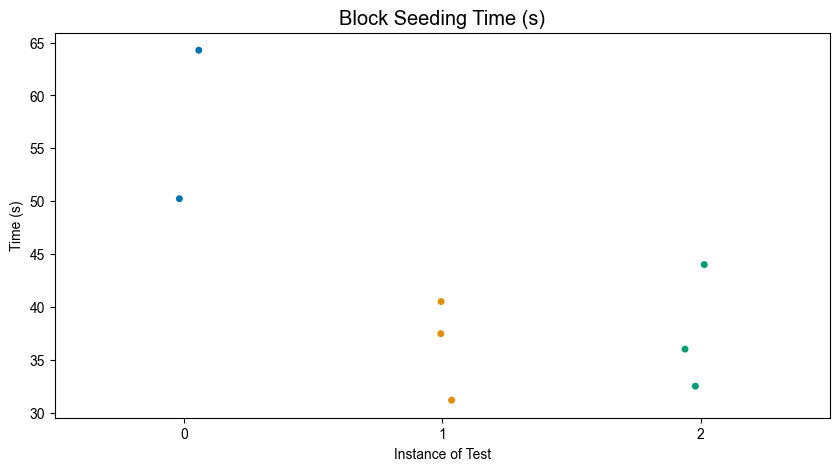

In [8]:
# ? How different are the metrics

# ? Builder Seeding Time

seeding_times = []

for test in tests:
    test_csvs = os.listdir(test)
    test_csvs = [os.path.join(test, csv) for csv in test_csvs if csv.endswith('.csv')]
    builder_csvs = [csv for csv in test_csvs if 'builder' in csv]
    latency_csv = [csv for csv in builder_csvs if 'latency' in csv][0]
    
    df = pd.read_csv(latency_csv)
    df = df['Block Seeding Duration (us)']
    df = pd.to_numeric(df, errors='coerce')
    df.dropna(inplace=True)
    seeding_times.append(df)

seeding_times = pd.concat(seeding_times, axis=1)
seeding_times = seeding_times / 1000000

fig, ax  = plt.subplots(figsize=(10, 5))
sns.set('paper', 'whitegrid', 'colorblind', font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.stripplot(data=seeding_times.values, ax=ax)
ax.set_title('Block Seeding Time (s)')
ax.set_xlabel('Instance of Test')
ax.set_ylabel('Time (s)')

# Final Plots

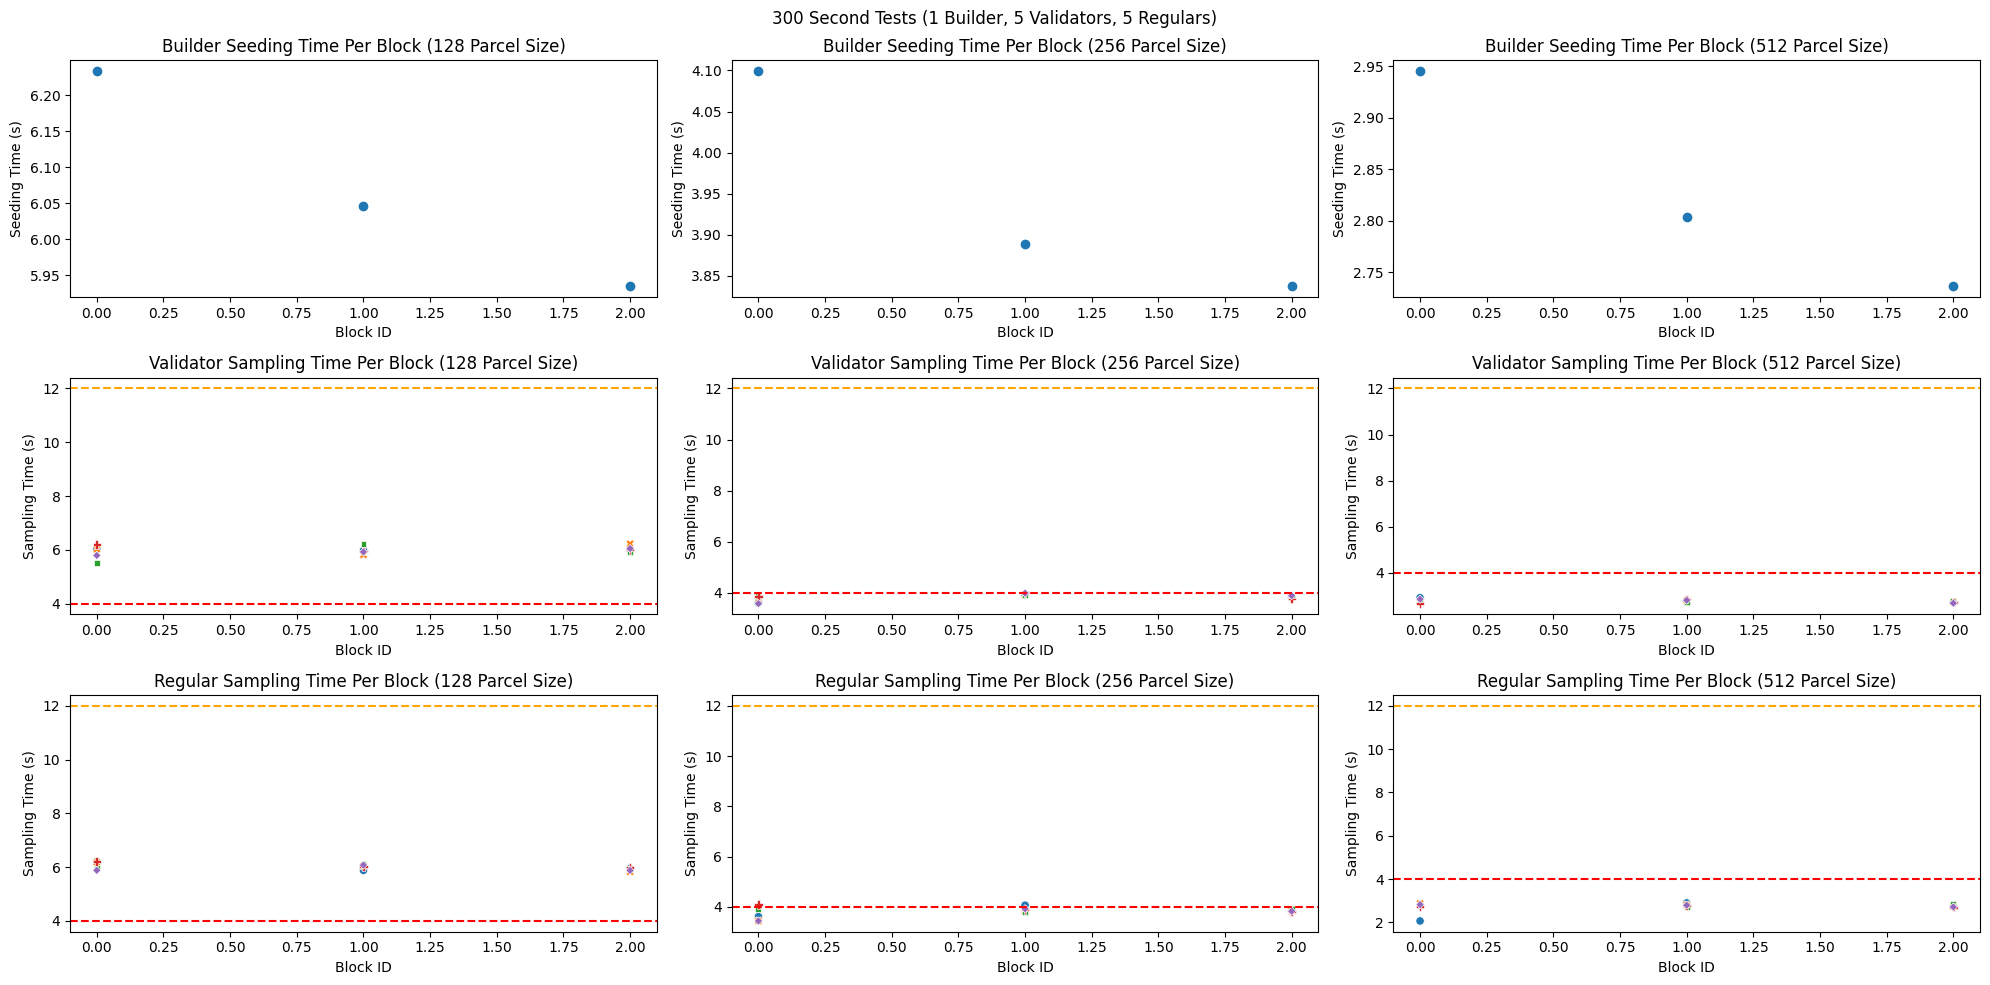

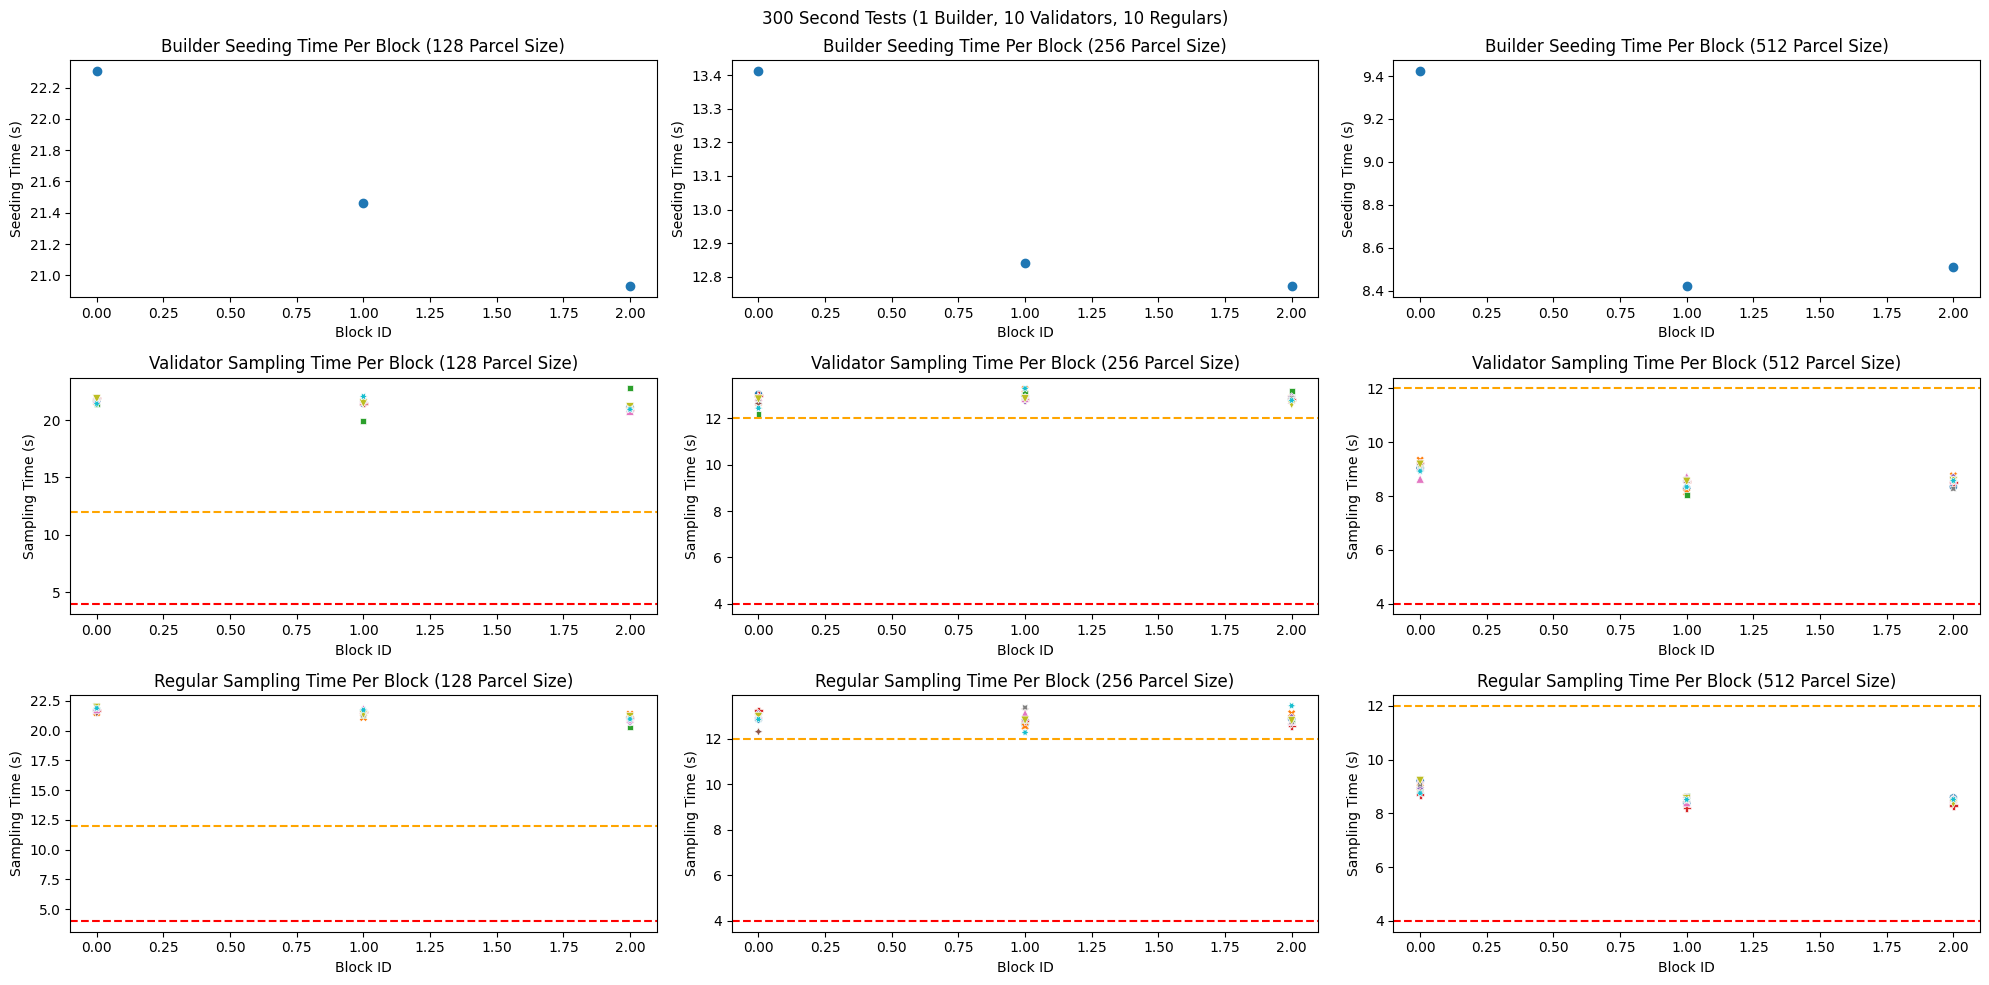

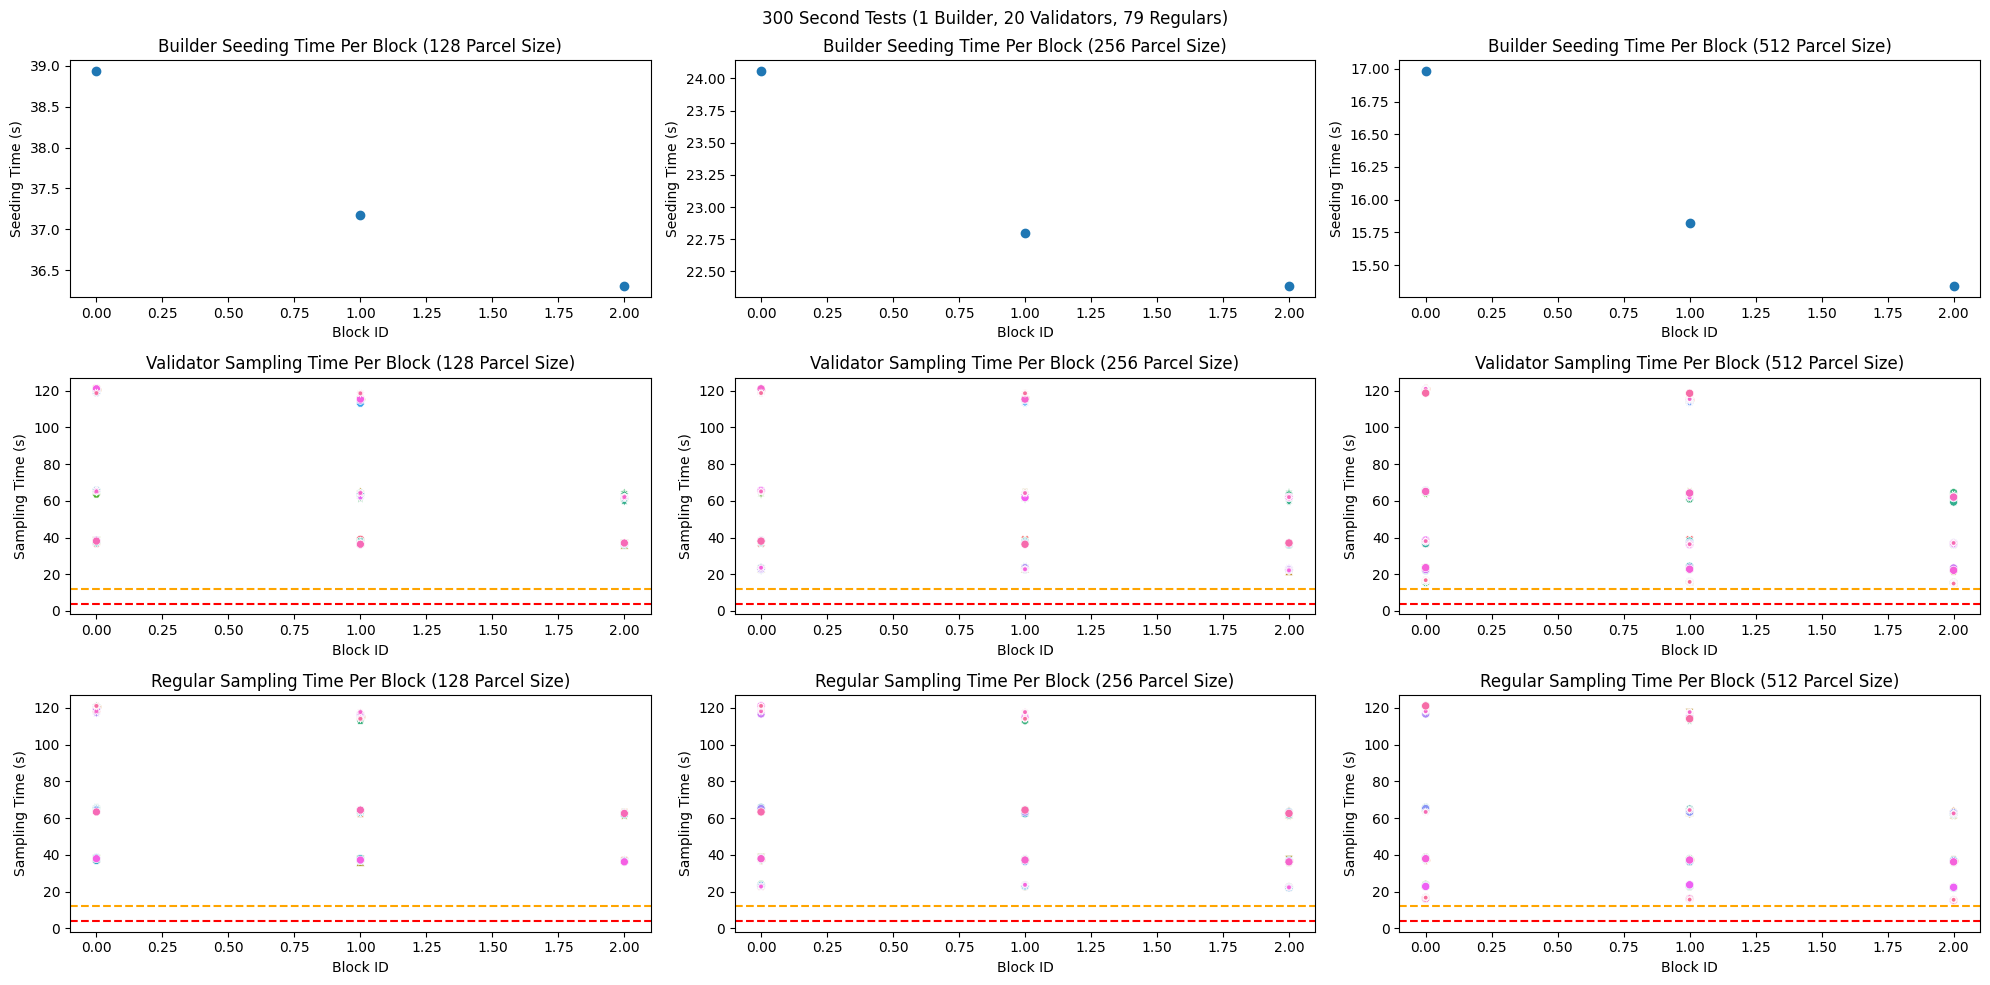

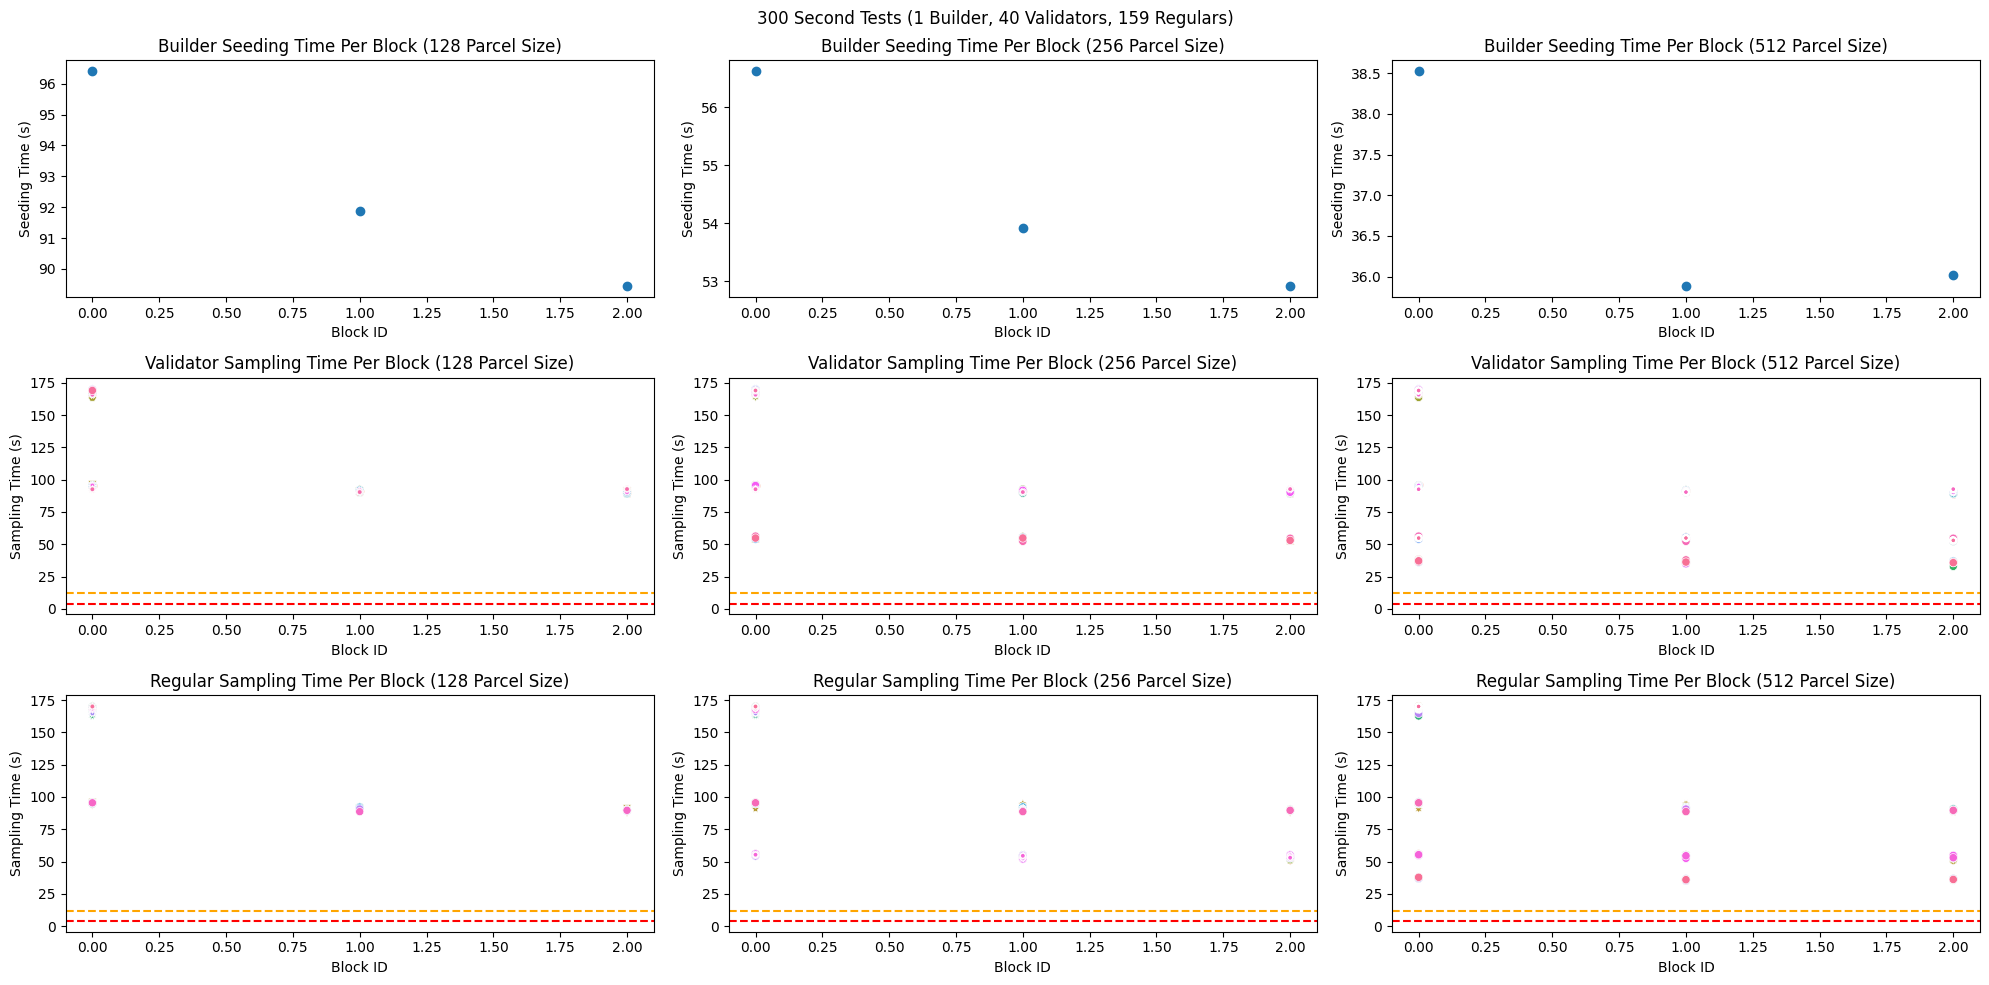

In [12]:
# Comment out tests as needed
# ? 1 Builder, 5 Validators, 5 Regulars, 300 sec, Vary Parcel Size
small_long_tests = [
    "300sec_1b5v5r_128ps_local_1",
    "300sec_1b5v5r_256ps_local_1",
    "300sec_1b5v5r_512ps_local_1"
]

# ? 1 Builder, 10 Validators, 10 Regulars, 120 sec, Vary Parcel Size
short_tests = [
    "120sec_1b10v10r_128ps_local_1",
    "120sec_1b10v10r_256ps_local_1",
    "120sec_1b10v10r_512ps_local_1"
]

# ? 1 Builder, 10 Validators, 10 Regulars, 300 sec, Vary Parcel Size
large_long_tests = [
    "300sec_1b10v10r_128ps_local_1",
    "300sec_1b10v10r_256ps_local_1",
    "300sec_1b10v10r_512ps_local_1"
]

small_grid_tests = [
    "300sec_1b5v5r_128ps_grid_1",
    "300sec_1b5v5r_256ps_grid_1",
    "300sec_1b5v5r_512ps_grid_1",
]

large_grid_tests_1 = [
    "300sec_1b10v10r_128ps_grid_1",
    "300sec_1b10v10r_256ps_grid_1",
    "300sec_1b10v10r_512ps_grid_1",
]

grid_tests_1b20v79r = [
    # "PANDAS_300s_1b_20_v_79r_32par_grid_1",
    # "PANDAS_300s_1b_20_v_79r_64par_grid_1",
    "PANDAS_300s_1b_20_v_79r_128par_grid_1",
    "PANDAS_300s_1b_20_v_79r_256par_grid_1",
    "PANDAS_300s_1b_20_v_79r_512par_grid_1",
]

grid_tests_1b40v159r = [
    # "PANDAS_300s_1b_20_v_79r_32par_grid_1",
    # "PANDAS_300s_1b_20_v_79r_64par_grid_1",
    "PANDAS_300s_1b_40_v_159r_128par_grid_1",
    "PANDAS_300s_1b_40_v_159r_256par_grid_1",
    "PANDAS_300s_1b_40_v_159r_512par_grid_1",
]

# plot_tests(small_long_tests, "300 Second Tests (1 Builder, 5 Validators, 5 Regulars)")
# plot_tests(large_long_tests, "300 Second Tests (1 Builder, 10 Validators, 10 Regulars)")

plot_tests(small_grid_tests, "300 Second Tests (1 Builder, 5 Validators, 5 Regulars)")
plot_tests(large_grid_tests_1, "300 Second Tests (1 Builder, 10 Validators, 10 Regulars)")
plot_tests(grid_tests_1b20v79r, "300 Second Tests (1 Builder, 20 Validators, 79 Regulars)")
plot_tests(grid_tests_1b40v159r, "300 Second Tests (1 Builder, 40 Validators, 159 Regulars)")
